# Simulação de Monte Carlo

PROBLEMA A SER RESOLVIDO: 

Tenho uma carteira com 5 ações. Dado a distribuição dos retornos dessa carteira no último ano:

    - Qual o máximo que eu posso perder nos próximos 3 anos, com uma confiança de 95%?
    - Qual a probabilidade de eu obter lucro?
    
RESOLUÇÃO:

Vamos simular 10 mil cenários da carteira com 10 ações nos próximos 10 anos e criar uma distribuição de retornos com os cenários. Pra isso, vamos utilizar Monte Carlo.

In [1]:
# importando as bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf 
from numpy import linalg as LA # função para decompor uma matriz

In [16]:
# pegando dados

lista_acoes = ['WEGE3', 'PCAR3', 'LREN3', 'PETR4', 'VALE3']
lista_acoes = [acao + ".SA" for acao in lista_acoes]

data_final = dt.datetime.now()
data_inicial = data_final - dt.timedelta(days=300) # 300 dias atrás

precos = yf.download(lista_acoes, data_inicial, data_final)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [17]:
# calculando retornos e pegando a matriz de covariância entre os retornos de cada empresa

retornos = precos.pct_change().dropna()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

FÓRMULA DOS RETORNOS SINTÉTICOS:

Retornos_sintéticos = média_retornos + Rpdf × L.

    - média_retornos = Média dos retornos.
    - Rpdf = Matriz aleatória gerada por alguma função de densidade de probabilidade.
    - L = Matriz triangular inferior proveniente de uma decomposição de Cholesky, usando como base a matriz de covariância dos dados originais.
    
POR QUE FAZER ISSO?

Nós assumimos que a distribuição de retornos é uma distribuição normal multivariada (isso é uma expansão da distribuição normal).

Quando geremos retornos aleátorios de cada ativo (Weg, Vale, etc), nós criamos vetores aleatórios descorrelacionados entre si. Para corrigir isso, precisamos correlacionar esses retornos (no mundo real isso é o que acontece) e, para isso, usamos a matriz triângular obtida a partir da covariância.

In [18]:
# premissas montecarlo

numero_simulacoes = 10000
dias_projetados = 252 * 3
capital_inicial = 1000

In [21]:
# gerando retorno médio

retorno_medio = retornos.mean(axis = 0).to_numpy() 
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

matriz_retorno_medio

array([[-0.00176973,  0.00024318,  0.00163909, -0.00015498, -0.00011092],
       [-0.00176973,  0.00024318,  0.00163909, -0.00015498, -0.00011092],
       [-0.00176973,  0.00024318,  0.00163909, -0.00015498, -0.00011092],
       ...,
       [-0.00176973,  0.00024318,  0.00163909, -0.00015498, -0.00011092],
       [-0.00176973,  0.00024318,  0.00163909, -0.00015498, -0.00011092],
       [-0.00176973,  0.00024318,  0.00163909, -0.00015498, -0.00011092]])

In [22]:
# gerando L

L = LA.cholesky(matriz_covariancia)
L

array([[ 3.29026487e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.35771297e-02,  2.86167344e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.02177297e-03,  4.81034617e-03,  2.26214762e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 1.98247891e-03,  4.40026857e-04,  3.49304020e-03,
         1.91639991e-02,  0.00000000e+00],
       [ 5.71264325e-03,  4.59548402e-04, -4.63245778e-05,
         2.33930688e-03,  1.48754242e-02]])

In [24]:
# gerando as simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes]) # cada coluna é uma simulação
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):

    Rpdf = np.random.normal(size=(dias_projetados, numero_acoes)) 
    
    retornos_sintéticos = matriz_retorno_medio + np.inner(Rpdf, L)  # unica coisa aleatória é o Rpdf
    
    retornos_carteira[:, s] = np.cumprod(np.inner(pesos_carteira, retornos_sintéticos) + 1) * capital_inicial
    
    montante_final[s] = retornos_carteira[-1, s]


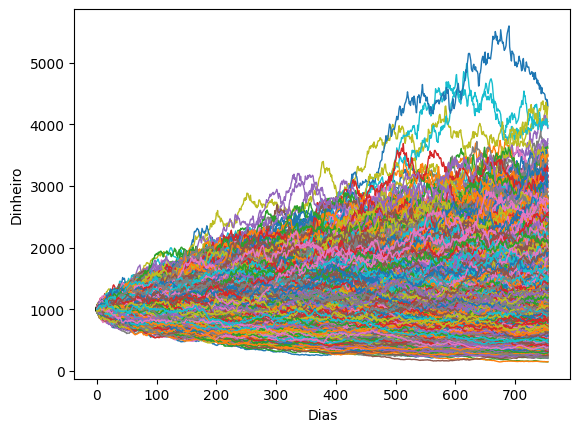

In [10]:
plt.plot(retornos_carteira, linewidth=1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')
plt.show()

In [25]:
# criando estatísticas para nossa carteira

montante_99 = str(np.percentile(montante_final, 1))
montante_95 = str(np.percentile(montante_final, 5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str((len(montante_final[montante_final > 1000])/
                                len(montante_final)) * 100) + "%"

In [27]:
print(f'''Ao investir R$ 1000,00 na carteira {lista_acoes}, 
podemos esperar esses resultados para os próximos 3 anos, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ {montante_mediano}. 

Com 95% de probabilidade, o montante será maior que R$ {montante_95}.

Com 99% de probabilidade, o montante será maior que R$ {montante_99}.

Em {cenarios_com_lucro} dos cenários, foi possível obter lucro nos próximos 3 anos.''')

Ao investir R$ 1000,00 na carteira ['WEGE3.SA', 'PCAR3.SA', 'LREN3.SA', 'PETR4.SA', 'VALE3.SA'], 
podemos esperar esses resultados para os próximos 3 anos, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ 891.3457950203915. 

Com 95% de probabilidade, o montante será maior que R$ 447.9472655359037.

Com 99% de probabilidade, o montante será maior que R$ 333.54147964178725.

Em 38.7% dos cenários, foi possível obter lucro nos próximos 3 anos.


UTILIDADES:

A partir dessas métricas, é possível calcular coisas como o VAR da carteira para diferentes intervalos de confiança e medir se o risco que você está correndo é compatível com o que você aguenta perder. No caso dessa carteira, uma queda de 42% está dentro dos 95% dos cenários mais possíveis de acontecer nos próximos 3 anos.

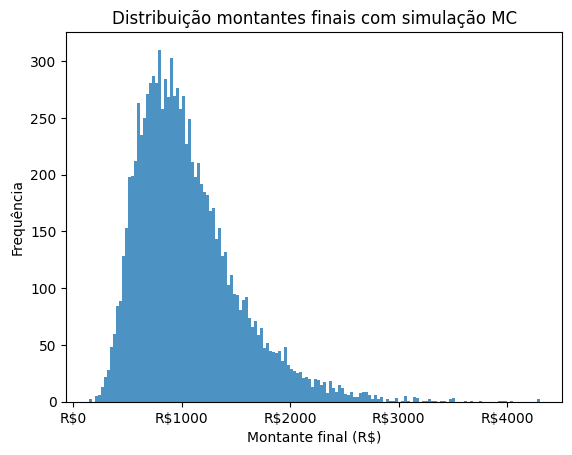

In [13]:
config = dict(histtype = "stepfilled", alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(montante_final, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title('Distribuição montantes finais com simulação MC')
plt.xlabel('Montante final (R$)')
plt.ylabel("Frequência")
plt.show()